### Libraries

In [ ]:
#Time Series libraries
import numpy as np
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import datetime
from fbprophet import Prophet
from math import sqrt
from random import random
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [ ]:
#function for evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y,pred):
    results = pd.DataFrame({'mean_absolute_error':mean_absolute_error(y, pred),
                           }, index=[0])
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    #results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y.values, pred.values)
    results['rmse'] = np.sqrt(results['mse'])
    return results

## Data Cleaning

In [ ]:
filename = 'Transient_Analysis.xlsx'
sheet ='Sheet2'

In [ ]:
#load data
data = pd.read_excel(filename, sheet_name=sheet)

In [ ]:
data['Time(s)'] = pd.to_datetime(data['Time(s)'], unit="s")

In [ ]:
#view top rows
data.head()

,Time(s),Material,Condition,Minimum(deg. C),Maximum(deg. C),Average(deg. C)
0,1970-01-01 00:00:00.010,CS,Transient Thermal values thru. The whole vessel,-805.78,1309.4,353.12
1,1970-01-01 00:00:00.020,CS,Transient Thermal values thru. The whole vessel,-795.60,1300.0,353.52
2,1970-01-01 00:00:00.030,CS,Transient Thermal values thru. The whole vessel,-785.52,1300.0,353.93
3,1970-01-01 00:00:00.040,CS,Transient Thermal values thru. The whole vessel,-775.53,1300.0,354.36
4,1970-01-01 00:00:00.050,CS,Transient Thermal values thru. The whole vessel,-765.63,1300.0,354.80


In [ ]:
print(data['Condition'].unique())  
print(data['Material'].unique()) 

['Transient Thermal values thru. The whole vessel'
 'Total Heat Flux values thru. The whole vessel'
 'Transient temp. at Topside Wall' 'Total heat flux at the Topside'
 'Transient temp. at the Vessel side' 'Total heat flux at the Vessel side'
 'Transient Temp. at the Bottom wall' 'Total heat flux at the Bottom wall']
['CS' 'SS' 'AL']


Analysis for Transient Thermal values thru. The whole vessel (SS)

In [ ]:
df = data[(data['Material']=='SS') & (data['Condition']=='Transient Thermal values thru. The whole vessel')]

In [ ]:
print(data['Condition'].unique())  
print(data['Material'].unique()) 

['Transient Thermal values thru. The whole vessel'
 'Total Heat Flux values thru. The whole vessel'
 'Transient temp. at Topside Wall' 'Total heat flux at the Topside'
 'Transient temp. at the Vessel side' 'Total heat flux at the Vessel side'
 'Transient Temp. at the Bottom wall' 'Total heat flux at the Bottom wall']
['CS' 'SS' 'AL']


In [ ]:
df.head()

,Time(s),Material,Condition,Minimum(deg. C),Maximum(deg. C),Average(deg. C)
1600,1970-01-01 00:00:00.010,SS,Transient Thermal values thru. The whole vessel,-813.68,1390.8,360.13
1601,1970-01-01 00:00:00.020,SS,Transient Thermal values thru. The whole vessel,-811.32,1381.2,367.39
1602,1970-01-01 00:00:00.030,SS,Transient Thermal values thru. The whole vessel,-808.97,1372.4,374.51
1603,1970-01-01 00:00:00.040,SS,Transient Thermal values thru. The whole vessel,-806.62,1364.7,381.52
1604,1970-01-01 00:00:00.050,SS,Transient Thermal values thru. The whole vessel,-804.27,1357.7,388.40


Forecasting Maximum Temperature

In [ ]:
target = 'Maximum(deg. C)'

In [ ]:
df = df.loc[:,['Time(s)', target]]
df['temp'] = df[target]
df = df.loc[:,['Time(s)', 'temp']]

In [ ]:
df.describe()

,temp
count,200.000000
mean,6837.334000
std,2523.778259
min,1351.700000
25%,5171.125000
50%,7412.550000
75%,8925.325000
max,10200.000000


In [ ]:
df.head()

,Time(s),temp
1600,1970-01-01 00:00:00.010,1390.8
1601,1970-01-01 00:00:00.020,1381.2
1602,1970-01-01 00:00:00.030,1372.4
1603,1970-01-01 00:00:00.040,1364.7
1604,1970-01-01 00:00:00.050,1357.7


## Visualization

In [ ]:
y = df.set_index('Time(s)')

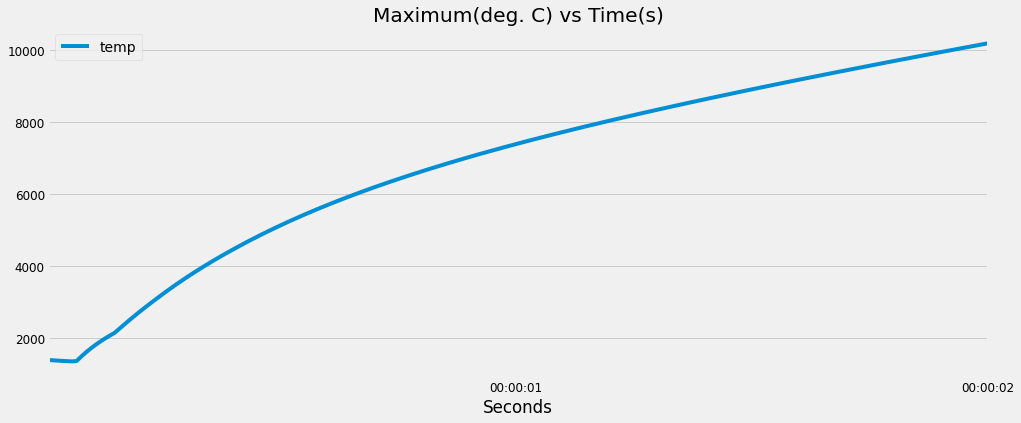

In [ ]:
#data visualization
y.plot(figsize=(15, 6))
plt.title('Maximum(deg. C) vs Time(s)')
plt.xlabel('Seconds')
plt.show()

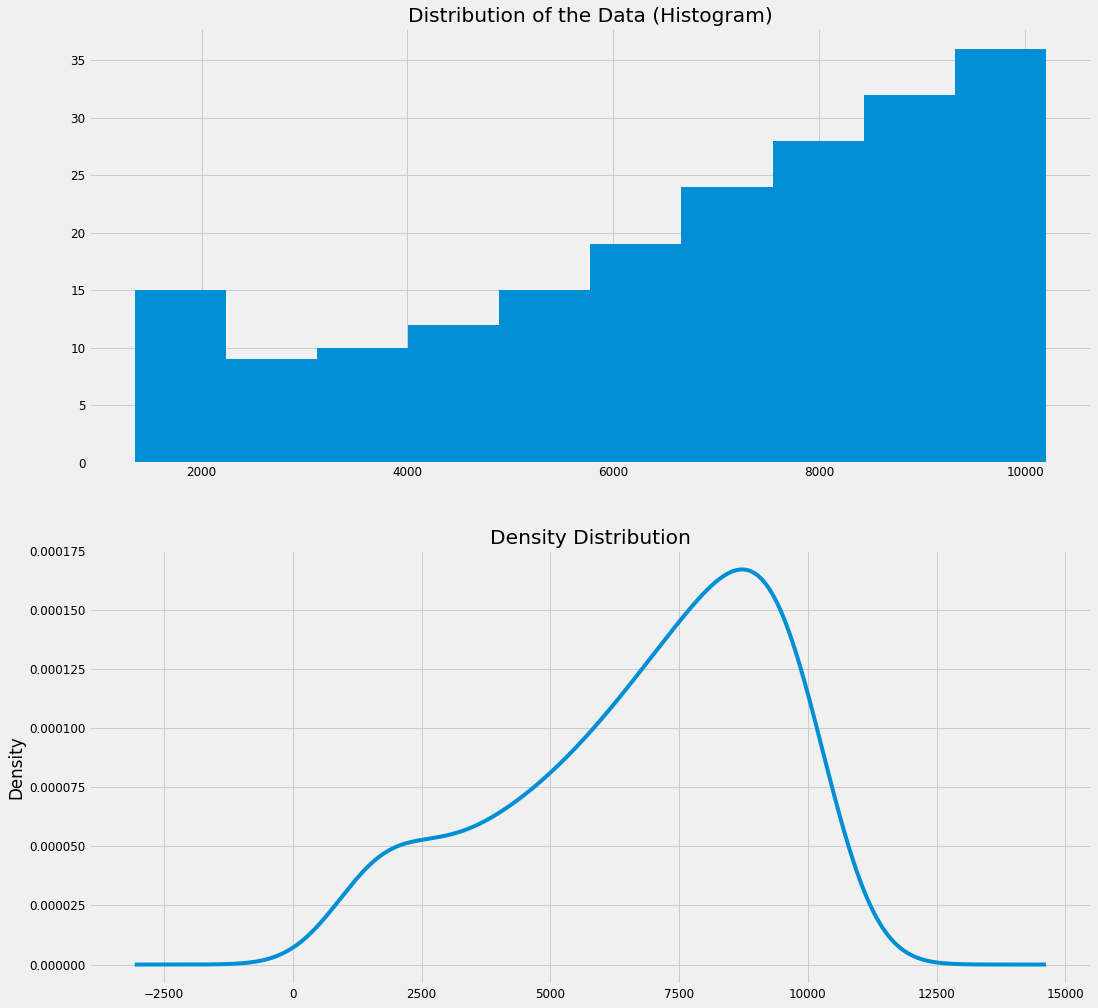

In [ ]:
#examining data distribution
plt.figure(1, figsize= (16,16))
plt.subplot(211)
plt.title('Distribution of the Data (Histogram)')
y.temp.hist()
#add bottom space
plt.subplots_adjust(bottom  = 0.05)    
plt.subplot(212)
plt.title('Density Distribution')
y.temp.plot(kind='kde')
plt.show()

In [ ]:
  #train validation split
train = df[:int(0.75*(len(df)))]
valid = df[int(0.75*(len(df))):]
train.set_index('Time(s)', inplace=True)
valid.set_index('Time(s)', inplace=True)

In [ ]:
print(train.head()), print(valid.head())

                           temp
Time(s)                        
1970-01-01 00:00:00.010  1390.8
1970-01-01 00:00:00.020  1381.2
1970-01-01 00:00:00.030  1372.4
1970-01-01 00:00:00.040  1364.7
1970-01-01 00:00:00.050  1357.7
                           temp
Time(s)                        
1970-01-01 00:00:01.510  8945.8
1970-01-01 00:00:01.520  8973.0
1970-01-01 00:00:01.530  9000.0
1970-01-01 00:00:01.540  9027.1
1970-01-01 00:00:01.550  9054.0


(None, None)

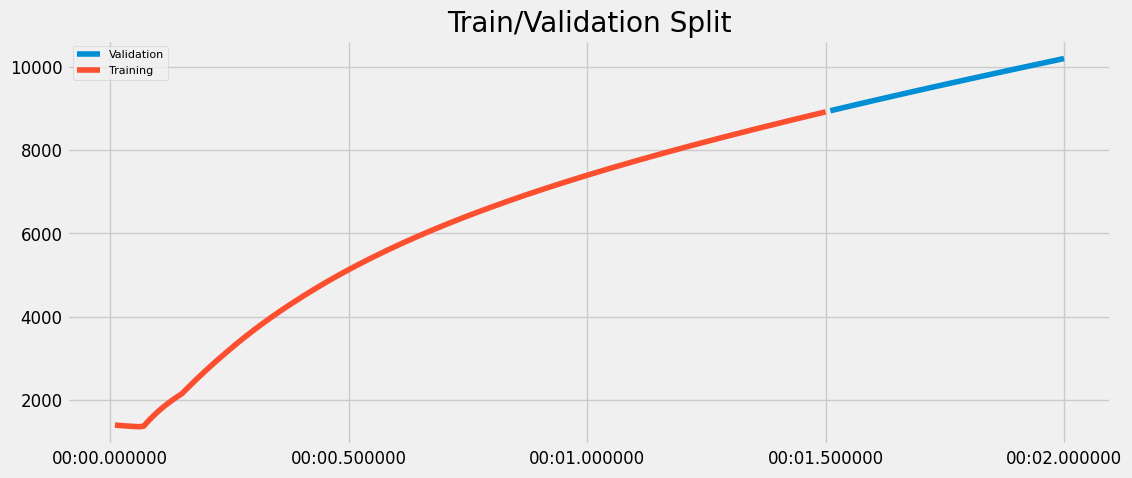

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(valid, label='Validation')
plt.plot(train, label='Training')
plt.title('Train/Validation Split')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Time Series Forcast 


In [ ]:
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.temp.values
#train_prophet['cap'] = max(train.temp)
#train_prophet['floor'] = min(train.temp)

In [ ]:
train_prophet.tail()

,ds,y
145,1970-01-01 00:00:01.460,8808.6
146,1970-01-01 00:00:01.470,8836.2
147,1970-01-01 00:00:01.480,8863.7
148,1970-01-01 00:00:01.490,8891.2
149,1970-01-01 00:00:01.500,8918.5


In [ ]:
#instantiate Prophet with only yearly seasonality as our data is monthly 
model = Prophet(seasonality_mode ='multiplicative', growth='linear') #seasonality_mode = 'additive', growth='logistic'

#fit the model with your dataframe
model.fit(train_prophet) #fit the model with your dataframe

#generate future time range till 5 seconds
future = model.make_future_dataframe(periods = 350, freq='10ms')
#future['cap'] = max(train.temp)
#future['floor'] = min(train.temp)
#view bottom five
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
495,1970-01-01 00:00:04.960
496,1970-01-01 00:00:04.970
497,1970-01-01 00:00:04.980
498,1970-01-01 00:00:04.990
499,1970-01-01 00:00:05.000


In [ ]:
#forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
495,1970-01-01 00:00:04.960,18949.206610,-4352.137225,43032.751359
496,1970-01-01 00:00:04.970,18978.171284,-4463.829450,43147.808660
497,1970-01-01 00:00:04.980,19007.135958,-4572.218502,43248.039093
498,1970-01-01 00:00:04.990,19036.100633,-4687.687661,43383.436885
499,1970-01-01 00:00:05.000,19065.065307,-4810.815243,43492.145082


In [ ]:
# To Export Predictions
#sub = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
#sub.to_csv("modelpred.csv", index=False)

In [ ]:
#set time as index
forecast.set_index('ds', inplace=True)

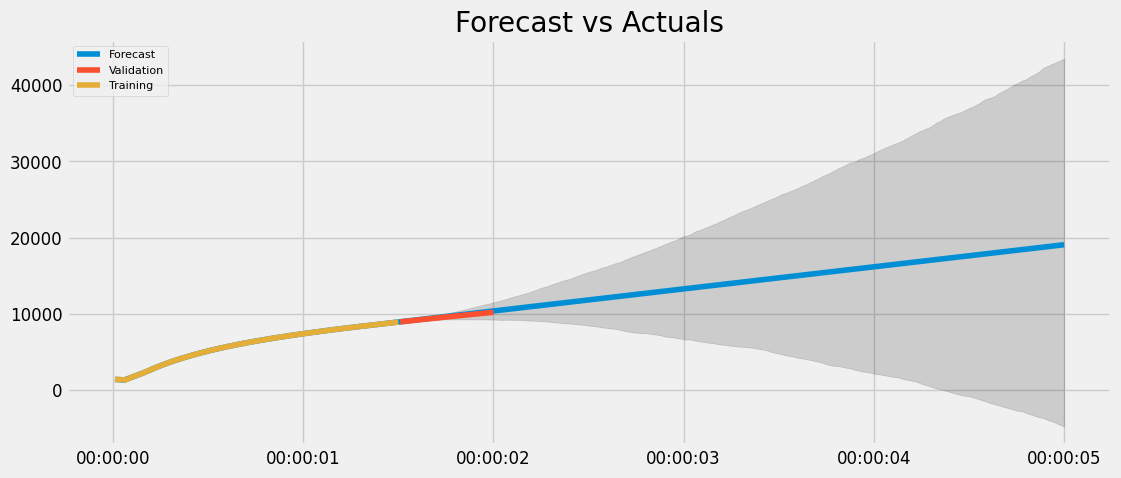

In [ ]:
#fc_series = forecast[len(train):].yhat
#lower_series = forecast[len(train):].yhat_lower
#upper_series = forecast[len(train):].yhat_upper

fc_series = forecast.yhat
lower_series = forecast.yhat_lower
upper_series = forecast.yhat_upper

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15) #limit/uncertainties
plt.plot(valid, label='Validation')
plt.plot(train, label='Training')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

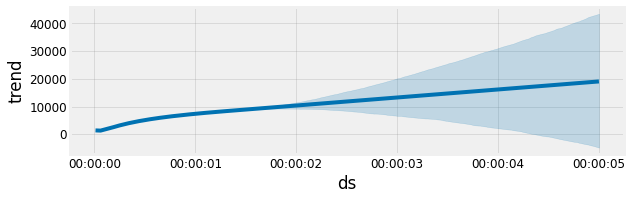

In [ ]:
#model components
forecast_ = forecast.reset_index()
model.plot_components(forecast_);

## Evaluation

In [ ]:
#making data frame
y_prophet = pd.DataFrame()
y_prophet['ds'] = y.index
y_prophet['y'] = y.temp.values

In [ ]:
#setting time as index
y_prophet = y_prophet.set_index('ds')
forecast_prophet = forecast

In [ ]:
#validation time period
validation_start_index = valid.index.min()
validation_end_index = valid.index.max()

In [ ]:
#train time period
training_start_index = train.index.min()
training_end_index = train.index.max()

#### Training Perfromance

In [ ]:
#evaluate forecast
evaluate_forecast(y_prophet.y[training_start_index:training_end_index], forecast_prophet.yhat[training_start_index:training_end_index])

,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,2.936391,0.936513,45.986836,0.122455,6.781359


The model accuracy is +/- 0.022909

#### Validation Performance

In [ ]:
#evaluate forecast
evaluate_forecast(y_prophet.y[validation_start_index:validation_end_index], forecast_prophet.yhat[validation_start_index:validation_end_index])

,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,81.758486,75.778486,9122.485941,0.83464,95.511706


In [ ]:
df.describe()

,temp
count,200.000000
mean,6837.334000
std,2523.778259
min,1351.700000
25%,5171.125000
50%,7412.550000
75%,8925.325000
max,10200.000000
